100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]



=== Round 1/10 (Started at 2025-06-12 13:34:41) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 verified and received update from client 7. Total updates: 8
EdgeNode 0 verified and received update from client 8. Total updates: 9
EdgeNode 0 verified and received update from client 9. Total updates: 10
EdgeNode 0 verified and received update from client 10. Total updates: 11
EdgeNode 0 verified and received update from client 11. Total updates: 12
EdgeNode 0 verified and received update from client 12. Total updates: 13
Edge

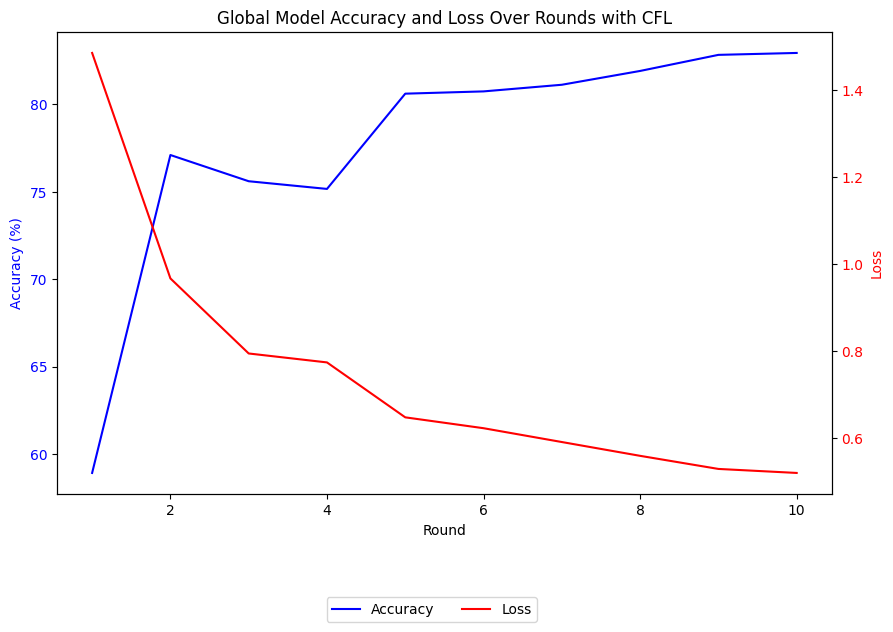

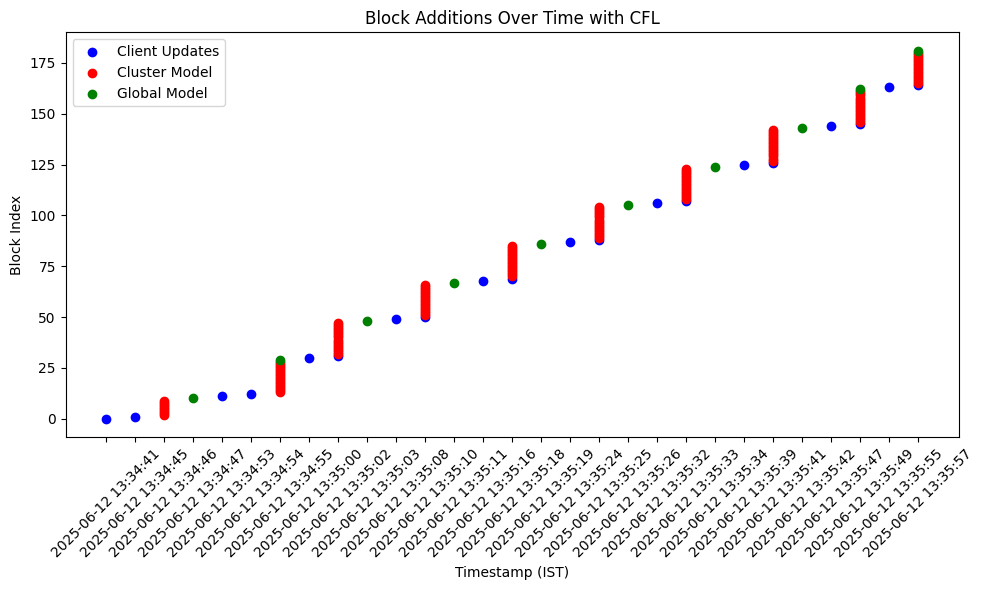

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 20
NUM_EDGE_NODES = 2
LEARNING_RATE = 0.01
EPOCHS = 5
BATCH_SIZE = 10
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5  # Majority for PoS
COSINE_THRESHOLD = 0.8  # CFL cosine similarity threshold

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    sorted_indices = np.argsort(dataset.targets.numpy())
    data_size = len(dataset) // num_clients
    client_data = []
    for i in range(num_clients):
        start_idx = i * data_size
        end_idx = (i + 1) * data_size
        indices = sorted_indices[start_idx:end_idx]
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(mnist_train, NUM_CLIENTS)

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids  # List of client IDs
        self.parameters = None  # Cluster model parameters

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.SGD(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None  # Store previous parameters for gradient computation

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        # Store current parameters before update
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        # Compute gradient for CFL clustering
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters.copy()
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []  # List of Cluster objects
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0

    def verify_client_update(self, client_params, median_params):
        sample_size = max(1000, len(client_params) // 10)
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        # Initialize with one cluster containing all clients
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 5  # Limit splits to prevent excessive clustering
        split_occurred = True
        split_count = 0

        while split_occurred and split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                # Get updates for clients in this cluster
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                # Compute gradients and mean gradient
                gradients = [grad for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                # Compute cosine similarities
                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    if norm_grad == 0:
                        similarities.append(0.0)
                    else:
                        cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean)
                        similarities.append(cos_sim)

                # Check if split is needed
                max_sim = max(similarities) if similarities else 0.0
                if max_sim > COSINE_THRESHOLD:
                    # Bipartition based on similarity
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:  # Ensure both groups are non-empty
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                # Store cluster model in blockchain
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)

    def exchange_parameter_updates(self, other_nodes):
        all_updates = self.parameter_updates.copy()
        all_clusters = self.clusters.copy()
        for node in other_nodes:
            all_updates.extend(node.parameter_updates)
            all_clusters.extend(node.clusters)
        self.parameter_updates = all_updates
        self.clusters = all_clusters
        for node in other_nodes:
            node.parameter_updates = all_updates.copy()
            node.clusters = all_clusters.copy()
        print(f"EdgeNode {self.id} exchanged updates and clusters. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        return np.mean(cluster_params, axis=0)

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = max(1000, len(proposed_params) // 10)
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)  # Fixed: Use reputation instead of stake
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        try:
            sample_size = max(1000, len(median_params) // 10)
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            print(f"Client {client.id} reward: {reward:.2f}")
            rewards.append((client.id, reward))
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC for and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        self.parameter_updates = []
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        consensus_start = time.time()
        client_start = time.time()
        # Collect client updates
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        # Perform CFL clustering
        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        # Propose and vote
        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()  # Lead node proposes
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)  # Highest stake leads
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node])
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                        node.clusters = lead_node.clusters
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:point+param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                phase_times['evaluation'].append(time.time() - eval_start)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}% , Loss: {loss:.4f}")

                # Update client models with cluster-specific parameters
                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                # Display clusters formed
                print(f"\nClusters formed in Round {round + 1}:")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")

                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                print("Max rejections reached")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
print(f"{phase:<20} {mean_time:>10.2f} {std_time:.2f} {total_time:.2f}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-' label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions.png')
plt.show()
plt.close()

MNIST-DATASET


=== Round 1/10 (Started at 2025-06-12 13:37:23) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 verified and received update from client 7. Total updates: 8
EdgeNode 0 verified and received update from client 8. Total updates: 9
EdgeNode 0 verified and received update from client 9. Total updates: 10
EdgeNode 0 verified and received update from client 10. Total updates: 11
EdgeNode 0 verified and received update from client 11. Total updates: 12
EdgeNode 0 verified and received update from client 12. Total updates: 13
Edge

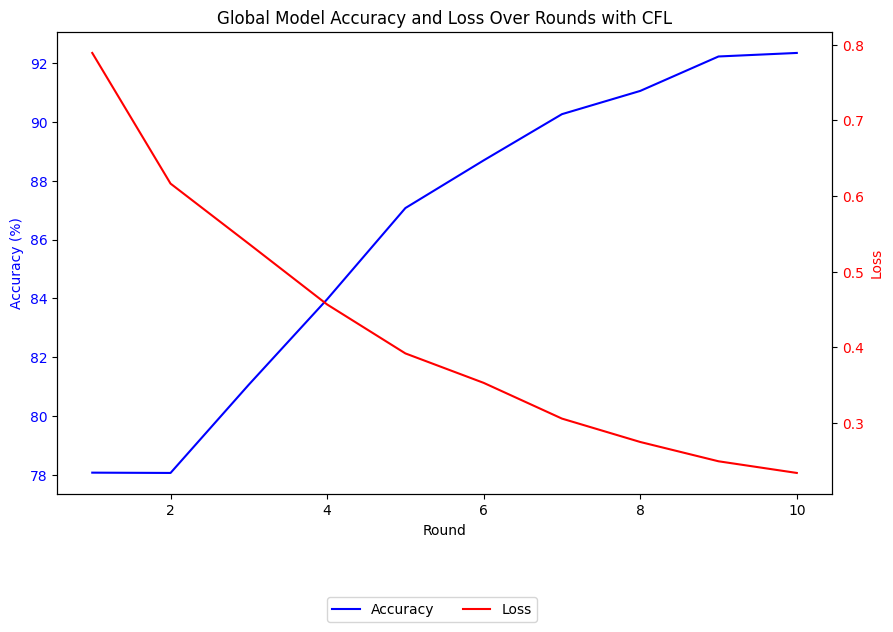

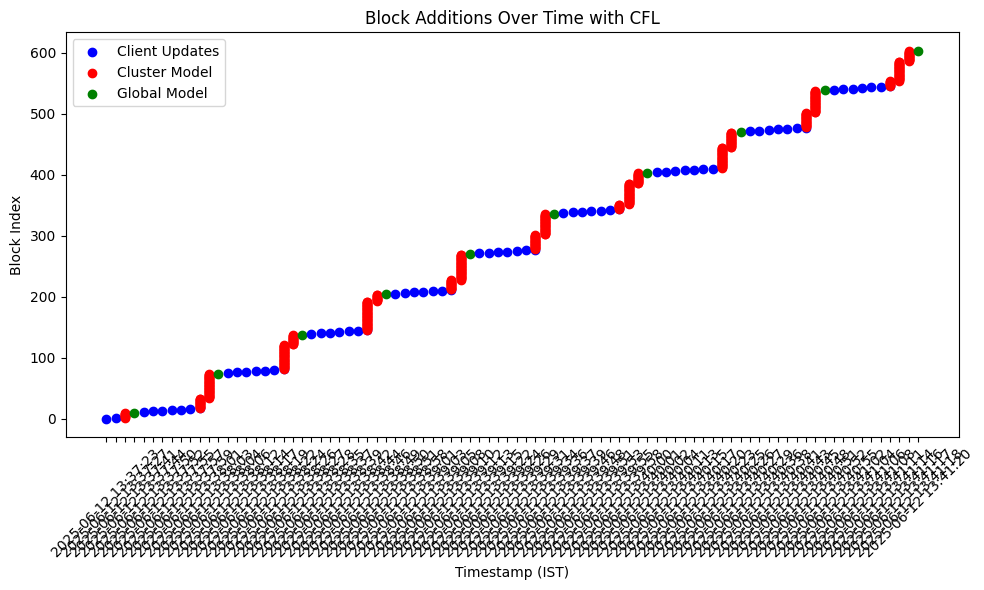

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25
NUM_EDGE_NODES = 7
LEARNING_RATE = 0.01
EPOCHS = 5
BATCH_SIZE = 10
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5  # Majority for PoS
COSINE_THRESHOLD = 0.8  # CFL cosine similarity threshold

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    sorted_indices = np.argsort(dataset.targets.numpy())
    data_size = len(dataset) // num_clients
    client_data = []
    for i in range(num_clients):
        start_idx = i * data_size
        end_idx = (i + 1) * data_size
        indices = sorted_indices[start_idx:end_idx]
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(mnist_train, NUM_CLIENTS)

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids  # List of client IDs
        self.parameters = None  # Cluster model parameters

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.SGD(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None  # Store previous parameters for gradient computation

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        # Store current parameters before update
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        # Compute gradient for CFL clustering
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters.copy()
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []  # List of Cluster objects
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0

    def verify_client_update(self, client_params, median_params):
        sample_size = max(1000, len(client_params) // 10)
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        # Initialize with one cluster containing all clients
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 5  # Limit splits to prevent excessive clustering
        split_occurred = True
        split_count = 0

        while split_occurred and split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                # Get updates for clients in this cluster
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                # Compute gradients and mean gradient
                gradients = [grad for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                # Compute cosine similarities
                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    if norm_grad == 0:
                        similarities.append(0.0)
                    else:
                        cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean)
                        similarities.append(cos_sim)

                # Check if split is needed
                max_sim = max(similarities) if similarities else 0.0
                if max_sim > COSINE_THRESHOLD:
                    # Bipartition based on similarity
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:  # Ensure both groups are non-empty
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                # Store cluster model in blockchain
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)

    def exchange_parameter_updates(self, other_nodes):
        all_updates = self.parameter_updates.copy()
        all_clusters = self.clusters.copy()
        for node in other_nodes:
            all_updates.extend(node.parameter_updates)
            all_clusters.extend(node.clusters)
        self.parameter_updates = all_updates
        self.clusters = all_clusters
        for node in other_nodes:
            node.parameter_updates = all_updates.copy()
            node.clusters = all_clusters.copy()
        print(f"EdgeNode {self.id} exchanged updates and clusters. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        return np.mean(cluster_params, axis=0)

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = max(1000, len(proposed_params) // 10)
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        try:
            sample_size = max(1000, len(median_params) // 10)
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            print(f"Client {client.id} reward: {reward:.2f}")
            rewards.append((client.id, reward))
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC for and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        self.parameter_updates = []
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        consensus_start = time.time()
        client_start = time.time()
        # Collect client updates
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        # Perform CFL clustering
        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        # Propose and vote
        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()  # Lead node proposes
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)  # Highest stake leads
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node])
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                        node.clusters = lead_node.clusters
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer+param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                phase_times['evaluation'].append(time.time() - eval_start)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}% , Loss: {loss:.4f}")

                # Update client models with cluster-specific parameters
                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                # Display clusters formed
                print(f"\nClusters formed in Round {round + 1}:")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")

                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                print("Max rejections reached")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:.2f} {total_time:.2f}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions.png')
plt.show()
plt.close()

Trial-Version


=== Round 1/10 (Started at 2025-06-18 10:21:36) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 verified and received update from client 7. Total updates: 8
EdgeNode 0 verified and received update from client 8. Total updates: 9
EdgeNode 0 verified and received update from client 9. Total updates: 10
EdgeNode 0 verified and received update from client 10. Total updates: 11
EdgeNode 0 verified and received update from client 11. Total updates: 12
EdgeNode 0 verified and received update from client 12. Total updates: 13
Edge

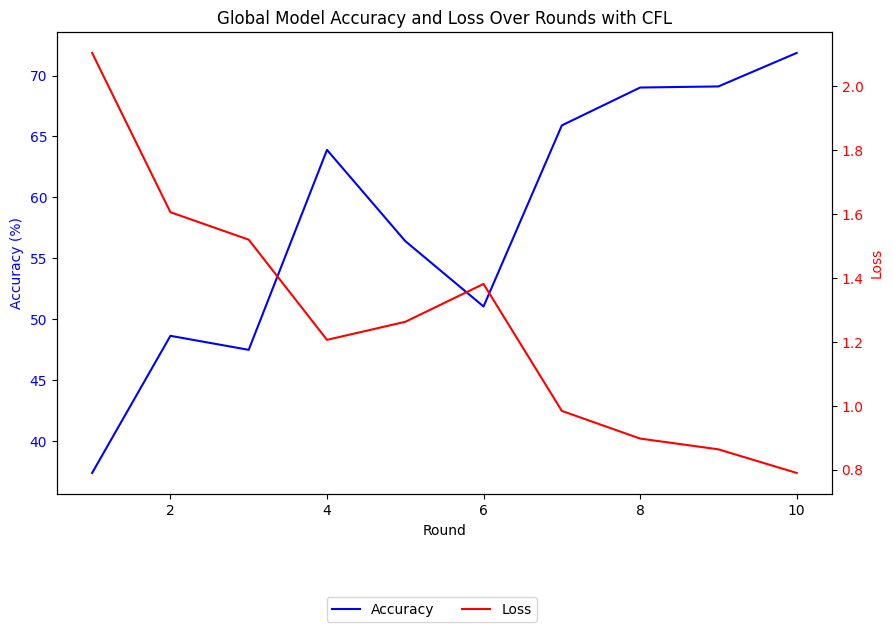

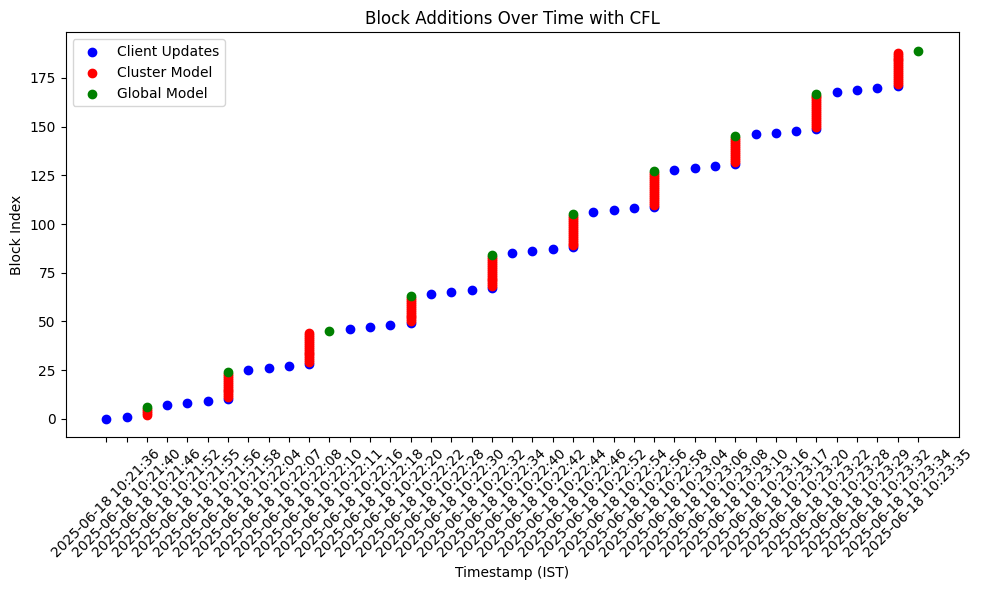

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25  # Client IDs 0-14
NUM_EDGE_NODES = 4
LEARNING_RATE = 0.01
EPOCHS = 5
BATCH_SIZE = 10
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5
COSINE_THRESHOLD = 0.85
ROUND_TIMEOUT = 300.0  # 5 minutes per round
SAMPLE_SIZE = 5000  # Reduced for HSIC and voting

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    sorted_indices = np.argsort(dataset.targets.numpy())
    data_size = len(dataset) // num_clients
    client_data = []
    for i in range(num_clients):
        start_idx = i * data_size
        end_idx = (i + 1) * data_size if i < num_clients - 1 else len(dataset)
        indices = sorted_indices[start_idx:end_idx]
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(mnist_train, NUM_CLIENTS)

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids
        self.parameters = None

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.SGD(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0
        self.cached_proposal = None

    def verify_client_update(self, client_params, median_params):
        sample_size = min(SAMPLE_SIZE, len(client_params))
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        if len(self.parameter_updates) < 2:
            print(f"EdgeNode {self.id}: Insufficient updates for clustering")
            self.clusters = [Cluster(0, list(range(len(clients))))]
            return
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 3
        split_count = 0
        sample_size = min(SAMPLE_SIZE, len(self.parameter_updates[0][1]))
        sample_indices = np.random.choice(len(self.parameter_updates[0][1]), sample_size, replace=False)

        while split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                gradients = [grad[sample_indices] for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean) if norm_grad > 0 else 0.0
                    similarities.append(cos_sim)

                if max(similarities, default=0.0) > COSINE_THRESHOLD:
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            if not split_occurred:
                break
            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)
        self.parameter_updates = []  # Clear updates after aggregation

    def exchange_parameter_updates(self, other_nodes, is_lead=False):
        if is_lead:
            print(f"EdgeNode {self.id} (lead) retained {len(self.clusters)} clusters")
        else:
            self.parameter_updates = []
            self.clusters = []
        for node in other_nodes:
            if is_lead:
                self.parameter_updates.extend(node.parameter_updates)
            else:
                node.parameter_updates = self.parameter_updates
                node.clusters = self.clusters
        print(f"EdgeNode {self.id} exchanged updates. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if self.cached_proposal is not None:
            return self.cached_proposal
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.cached_proposal = np.mean(cluster_params, axis=0)
        return self.cached_proposal

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = min(SAMPLE_SIZE, len(proposed_params))
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        if np.allclose(median_params, global_params, rtol=1e-5, atol=1e-8):
            print("Parameters are nearly identical, HSIC set to 1.0")
            return 1.0
        try:
            sample_size = min(SAMPLE_SIZE, len(median_params))
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        print("Triggering SC_4: Computing client rewards")
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            rewards.append((client.id, reward))
            print(f"Client {client.id} reward: {reward:.2f}")
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC value and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        self.parameter_updates = []
        self.cached_proposal = None
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        if time.time() - round_start > ROUND_TIMEOUT:
            print(f"Round {round + 1} timed out after {ROUND_TIMEOUT} seconds")
            break
        consensus_start = time.time()
        client_start = time.time()
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            node.cached_proposal = None
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)
            print(f"Selected lead node: ID {lead_node.id} with reputation {lead_node.reputation:.2f}")
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node], is_lead=True)
            for node in edge_nodes:
                if node != lead_node:
                    node.clusters = lead_node.clusters
                    node.parameter_updates = lead_node.parameter_updates
                    node.global_parameters = lead_node.global_parameters
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer + param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                phase_times['evaluation'].append(time.time() - eval_start)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                print(f"\nClusters formed in Round {round + 1}:")
                print(f"Lead Node ID: {lead_node.id}, Number of Clusters: {len(lead_node.clusters)}")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")
                print("Cluster counts after synchronization:")
                for node in edge_nodes:
                    print(f"Node {node.id}: {len(node.clusters)} clusters")

                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
                node.cached_proposal = None
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:>10.2f} {total_time:>10.2f}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions.png')
plt.show()
plt.close()

correct_Version

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.14MB/s]



=== Round 1/10 (Started at 2025-06-23 14:26:56) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 verified and received update from client 7. Total updates: 8
EdgeNode 0 verified and received update from client 8. Total updates: 9
EdgeNode 0 verified and received update from client 9. Total updates: 10
EdgeNode 0 verified and received update from client 10. Total updates: 11
EdgeNode 0 verified and received update from client 11. Total updates: 12
EdgeNode 0 verified and received update from client 12. Total updates: 13
Edge

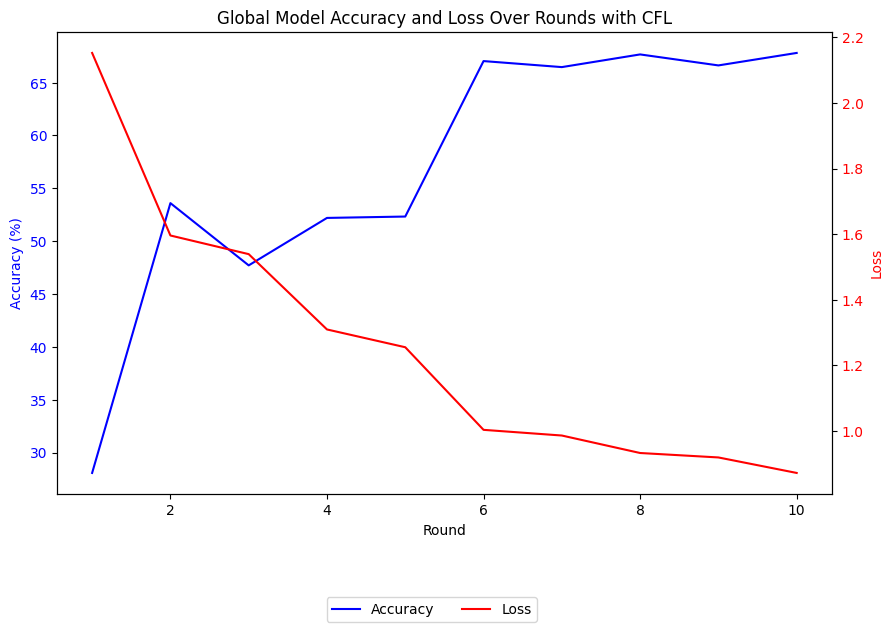

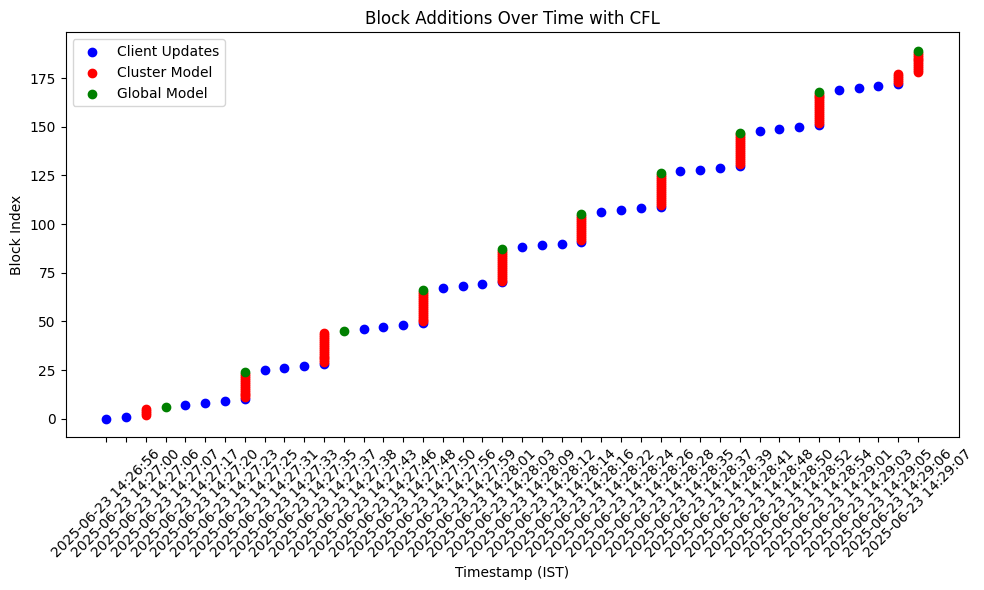

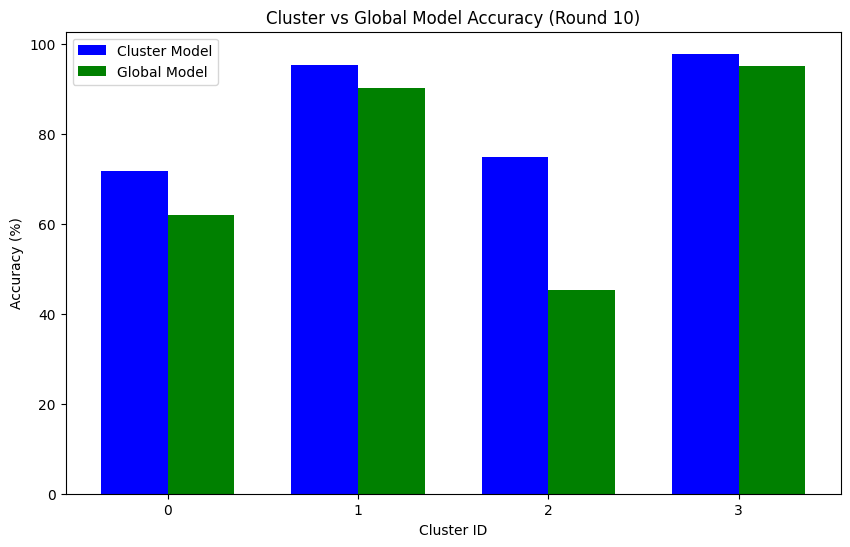

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25
NUM_EDGE_NODES = 4
LEARNING_RATE = 0.01
EPOCHS = 5
BATCH_SIZE = 10
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5
COSINE_THRESHOLD = 0.85
ROUND_TIMEOUT = 300.0
SAMPLE_SIZE = 5000

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    sorted_indices = np.argsort(dataset.targets.numpy())
    data_size = len(dataset) // num_clients
    client_data = []
    for i in range(num_clients):
        start_idx = i * data_size
        end_idx = (i + 1) * data_size if i < num_clients - 1 else len(dataset)
        indices = sorted_indices[start_idx:end_idx]
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(mnist_train, NUM_CLIENTS)
client_test_datasets = create_non_iid_data(mnist_test, NUM_CLIENTS)

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids
        self.parameters = None

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.SGD(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0
        self.cached_proposal = None

    def verify_client_update(self, client_params, median_params):
        sample_size = min(SAMPLE_SIZE, len(client_params))
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        if len(self.parameter_updates) < 2:
            print(f"EdgeNode {self.id}: Insufficient updates for clustering")
            self.clusters = [Cluster(0, list(range(len(clients))))]
            return
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 3
        split_count = 0
        sample_size = min(SAMPLE_SIZE, len(self.parameter_updates[0][1]))
        sample_indices = np.random.choice(len(self.parameter_updates[0][1]), sample_size, replace=False)

        while split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                gradients = [grad[sample_indices] for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean) if norm_grad > 0 else 0.0
                    similarities.append(cos_sim)

                if max(similarities, default=0.0) > COSINE_THRESHOLD:
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            if not split_occurred:
                break
            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)
        self.parameter_updates = []

    def exchange_parameter_updates(self, other_nodes, is_lead=False):
        if is_lead:
            print(f"EdgeNode {self.id} (lead) retained {len(self.clusters)} clusters")
        else:
            self.parameter_updates = []
            self.clusters = []
        for node in other_nodes:
            if is_lead:
                self.parameter_updates.extend(node.parameter_updates)
            else:
                node.parameter_updates = self.parameter_updates
                node.clusters = self.clusters
        print(f"EdgeNode {self.id} exchanged updates. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if self.cached_proposal is not None:
            return self.cached_proposal
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.cached_proposal = np.mean(cluster_params, axis=0)
        return self.cached_proposal

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = min(SAMPLE_SIZE, len(proposed_params))
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        if np.allclose(median_params, global_params, rtol=1e-5, atol=1e-8):
            print("Parameters are nearly identical, HSIC set to 1.0")
            return 1.0
        try:
            sample_size = min(SAMPLE_SIZE, len(median_params))
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        print("Triggering SC_4: Computing client rewards")
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            rewards.append((client.id, reward))
            print(f"Client {client.id} reward: {reward:.2f}")
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC value and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        self.parameter_updates = []
        self.cached_proposal = None
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total if total > 0 else 0.0
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0.0
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
cluster_accuracies = []
global_per_cluster_accuracies = []
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        if time.time() - round_start > ROUND_TIMEOUT:
            print(f"Round {round + 1} timed out after {ROUND_TIMEOUT} seconds")
            break
        consensus_start = time.time()
        client_start = time.time()
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            node.cached_proposal = None
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)
            print(f"Selected lead node: ID {lead_node.id} with reputation {lead_node.reputation:.2f}")
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node], is_lead=True)
            for node in edge_nodes:
                if node != lead_node:
                    node.clusters = lead_node.clusters
                    node.parameter_updates = lead_node.parameter_updates
                    node.global_parameters = lead_node.global_parameters
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer + param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

                # Cluster-specific evaluation
                cluster_accs = {}
                global_accs = {}
                for cluster in lead_node.clusters:
                    # Combine test data for clients in the cluster
                    cluster_test_data = []
                    for cid in cluster.client_ids:
                        cluster_test_data.extend(client_test_datasets[cid])
                    if not cluster_test_data:
                        print(f"Cluster {cluster.id} has no test data")
                        continue
                    cluster_test_loader = torch.utils.data.DataLoader(cluster_test_data, batch_size=64, shuffle=False)

                    # Evaluate cluster model
                    if cluster.parameters is not None:
                        cluster_model = SimpleNN()
                        pointer = 0
                        for param in cluster_model.parameters():
                            param_size = param.numel()
                            param.data = torch.from_numpy(cluster.parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                            pointer += param_size
                        cluster_acc, _ = evaluate_model(cluster_model, cluster_test_loader)
                        cluster_accs[cluster.id] = cluster_acc
                        print(f"Cluster {cluster.id} model accuracy: {cluster_acc:.2f}%")
                    else:
                        print(f"Cluster {cluster.id} has no parameters")
                        cluster_accs[cluster.id] = 0.0

                    # Evaluate global model on cluster data
                    global_acc, _ = evaluate_model(test_model, cluster_test_loader)
                    global_accs[cluster.id] = global_acc
                    print(f"Global model accuracy on Cluster {cluster.id} data: {global_acc:.2f}%")

                cluster_accuracies.append(cluster_accs)
                global_per_cluster_accuracies.append(global_accs)

                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                print(f"\nClusters formed in Round {round + 1}:")
                print(f"Lead Node ID: {lead_node.id}, Number of Clusters: {len(lead_node.clusters)}")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")
                print("Cluster counts after synchronization:")
                for node in edge_nodes:
                    print(f"Node {node.id}: {len(node.clusters)} clusters")

                phase_times['evaluation'].append(time.time() - eval_start)
                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
                node.cached_proposal = None
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:>10.2f} {total_time:>10.2f}")

# Print comparison table
print("\nPerformance Comparison Across Rounds:")
print(f"{'Round':<10} {'Cluster ID':<12} {'Cluster Acc (%)':<15} {'Global Acc (%)':<15} {'Clients':<20}")
for r in range(len(cluster_accuracies)):
    print(f"\nRound {r + 1}")
    for cid in cluster_accuracies[r]:
        print(f"{'':<10} {cid:<12} {cluster_accuracies[r][cid]:<15.2f} {global_per_cluster_accuracies[r][cid]:<15.2f} {lead_node.clusters[cid].client_ids if cid in [c.id for c in lead_node.clusters] else []}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions.png')
plt.show()
plt.close()

# Plot cluster vs global model accuracy comparison
if cluster_accuracies:
    final_round = len(cluster_accuracies) - 1
    cluster_ids = sorted(cluster_accuracies[final_round].keys())
    cluster_accs = [cluster_accuracies[final_round][cid] for cid in cluster_ids]
    global_accs = [global_per_cluster_accuracies[final_round][cid] for cid in cluster_ids]

    x = np.arange(len(cluster_ids))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, cluster_accs, width, label='Cluster Model', color='blue')
    ax.bar(x + width/2, global_accs, width, label='Global Model', color='green')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Cluster vs Global Model Accuracy (Round {final_round + 1})')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_ids)
    ax.legend()
    plt.savefig('cluster_vs_global_accuracy.png')
    plt.show()
    plt.close()

CIFAR-10

100%|██████████| 170M/170M [00:03<00:00, 51.7MB/s]



=== Round 1/10 (Started at 2025-06-26 12:29:05) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 rejected update from client 7 due to low HSIC: 0.8950
EdgeNode 0 rejected update from client 8 due to low HSIC: 0.8898
EdgeNode 0 rejected update from client 9 due to low HSIC: 0.8984
EdgeNode 0 rejected update from client 10 due to low HSIC: 0.8817
EdgeNode 0 rejected update from client 11 due to low HSIC: 0.8558
EdgeNode 0 rejected update from client 12 due to low HSIC: 0.8566
EdgeNode 0 rejected update from client 13 due to l

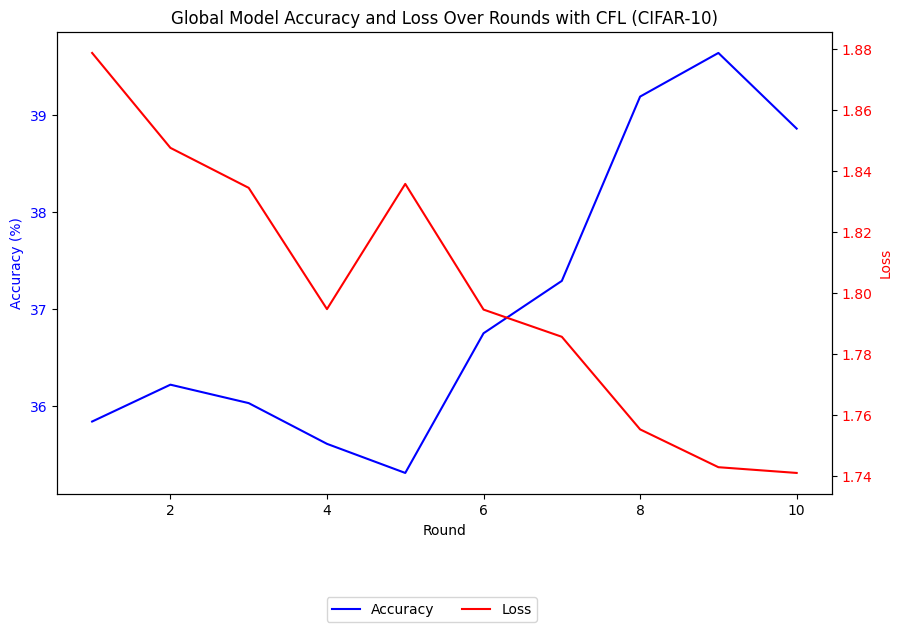

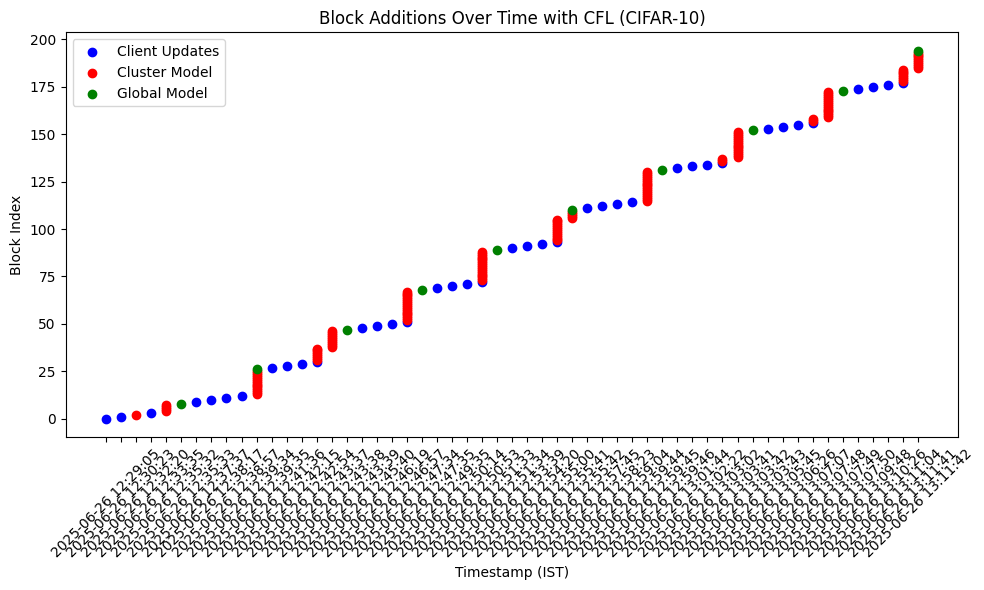

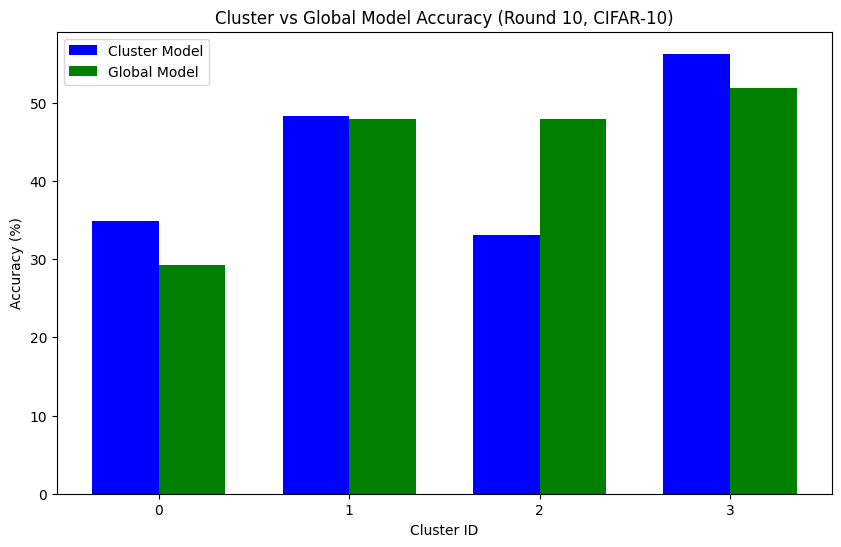

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25
NUM_EDGE_NODES = 4
LEARNING_RATE = 0.001  # Adjusted for CIFAR-10
EPOCHS = 3  # Reduced due to CIFAR-10 complexity
BATCH_SIZE = 32  # Increased for faster training
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5
COSINE_THRESHOLD = 0.85
ROUND_TIMEOUT = 300.0
SAMPLE_SIZE = 5000

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
cifar10_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    # Group data by class
    class_indices = [[] for _ in range(10)]  # 10 classes in CIFAR-10
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Assign 2-3 random classes to each client
    client_data = []
    for _ in range(num_clients):
        num_classes = random.randint(2, 3)
        selected_classes = random.sample(range(10), num_classes)
        indices = []
        for cls in selected_classes:
            # Take a portion of data from each class
            class_subset = random.sample(class_indices[cls], len(class_indices[cls]) // num_clients)
            indices.extend(class_subset)
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(cifar10_train, NUM_CLIENTS)
client_test_datasets = create_non_iid_data(cifar10_test, NUM_CLIENTS)

# Neural Network Model (CNN for CIFAR-10)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids
        self.parameters = None

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)  # Changed to Adam for CIFAR-10
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0
        self.cached_proposal = None

    def verify_client_update(self, client_params, median_params):
        sample_size = min(SAMPLE_SIZE, len(client_params))
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        if len(self.parameter_updates) < 2:
            print(f"EdgeNode {self.id}: Insufficient updates for clustering")
            self.clusters = [Cluster(0, list(range(len(clients))))]
            return
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 3
        split_count = 0
        sample_size = min(SAMPLE_SIZE, len(self.parameter_updates[0][1]))
        sample_indices = np.random.choice(len(self.parameter_updates[0][1]), sample_size, replace=False)

        while split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                gradients = [grad[sample_indices] for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean) if norm_grad > 0 else 0.0
                    similarities.append(cos_sim)

                if max(similarities, default=0.0) > COSINE_THRESHOLD:
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            if not split_occurred:
                break
            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)
        self.parameter_updates = []

    def exchange_parameter_updates(self, other_nodes, is_lead=False):
        if is_lead:
            print(f"EdgeNode {self.id} (lead) retained {len(self.clusters)} clusters")
        else:
            self.parameter_updates = []
            self.clusters = []
        for node in other_nodes:
            if is_lead:
                self.parameter_updates.extend(node.parameter_updates)
            else:
                node.parameter_updates = self.parameter_updates
                node.clusters = self.clusters
        print(f"EdgeNode {self.id} exchanged updates. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if self.cached_proposal is not None:
            return self.cached_proposal
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.cached_proposal = np.mean(cluster_params, axis=0)
        return self.cached_proposal

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = min(SAMPLE_SIZE, len(proposed_params))
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        if np.allclose(median_params, global_params, rtol=1e-5, atol=1e-8):
            print("Parameters are nearly identical, HSIC set to 1.0")
            return 1.0
        try:
            sample_size = min(SAMPLE_SIZE, len(median_params))
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        print("Triggering SC_4: Computing client rewards")
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            rewards.append((client.id, reward))
            print(f"Client {client.id} reward: {reward:.2f}")
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC value and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        self.parameter_updates = []
        self.cached_proposal = None
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total if total > 0 else 0.0
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0.0
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
cluster_accuracies = []
global_per_cluster_accuracies = []
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        if time.time() - round_start > ROUND_TIMEOUT:
            print(f"Round {round + 1} timed out after {ROUND_TIMEOUT} seconds")
            break
        consensus_start = time.time()
        client_start = time.time()
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            node.cached_proposal = None
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)
            print(f"Selected lead node: ID {lead_node.id} with reputation {lead_node.reputation:.2f}")
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node], is_lead=True)
            for node in edge_nodes:
                if node != lead_node:
                    node.clusters = lead_node.clusters
                    node.parameter_updates = lead_node.parameter_updates
                    node.global_parameters = lead_node.global_parameters
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer + param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

                # Cluster-specific evaluation
                cluster_accs = {}
                global_accs = {}
                for cluster in lead_node.clusters:
                    # Combine test data for clients in the cluster
                    cluster_test_data = []
                    for cid in cluster.client_ids:
                        cluster_test_data.extend(client_test_datasets[cid])
                    if not cluster_test_data:
                        print(f"Cluster {cluster.id} has no test data")
                        continue
                    cluster_test_loader = torch.utils.data.DataLoader(cluster_test_data, batch_size=64, shuffle=False)

                    # Evaluate cluster model
                    if cluster.parameters is not None:
                        cluster_model = SimpleNN()
                        pointer = 0
                        for param in cluster_model.parameters():
                            param_size = param.numel()
                            param.data = torch.from_numpy(cluster.parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                            pointer += param_size
                        cluster_acc, _ = evaluate_model(cluster_model, cluster_test_loader)
                        cluster_accs[cluster.id] = cluster_acc
                        print(f"Cluster {cluster.id} model accuracy: {cluster_acc:.2f}%")
                    else:
                        print(f"Cluster {cluster.id} has no parameters")
                        cluster_accs[cluster.id] = 0.0

                    # Evaluate global model on cluster data
                    global_acc, _ = evaluate_model(test_model, cluster_test_loader)
                    global_accs[cluster.id] = global_acc
                    print(f"Global model accuracy on Cluster {cluster.id} data: {global_acc:.2f}%")

                cluster_accuracies.append(cluster_accs)
                global_per_cluster_accuracies.append(global_accs)

                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                print(f"\nClusters formed in Round {round + 1}:")
                print(f"Lead Node ID: {lead_node.id}, Number of Clusters: {len(lead_node.clusters)}")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")
                print("Cluster counts after synchronization:")
                for node in edge_nodes:
                    print(f"Node {node.id}: {len(node.clusters)} clusters")

                phase_times['evaluation'].append(time.time() - eval_start)
                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
                node.cached_proposal = None
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:>10.2f} {total_time:>10.2f}")

# Print comparison table
print("\nPerformance Comparison Across Rounds:")
print(f"{'Round':<10} {'Cluster ID':<12} {'Cluster Acc (%)':<15} {'Global Acc (%)':<15} {'Clients':<20}")
for r in range(len(cluster_accuracies)):
    print(f"\nRound {r + 1}")
    for cid in cluster_accuracies[r]:
        print(f"{'':<10} {cid:<12} {cluster_accuracies[r][cid]:<15.2f} {global_per_cluster_accuracies[r][cid]:<15.2f} {lead_node.clusters[cid].client_ids if cid in [c.id for c in lead_node.clusters] else []}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL (CIFAR-10)')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss_cifar10.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL (CIFAR-10)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions_cifar10.png')
plt.show()
plt.close()

# Plot cluster vs global model accuracy comparison
if cluster_accuracies:
    final_round = len(cluster_accuracies) - 1
    cluster_ids = sorted(cluster_accuracies[final_round].keys())
    cluster_accs = [cluster_accuracies[final_round][cid] for cid in cluster_ids]
    global_accs = [global_per_cluster_accuracies[final_round][cid] for cid in cluster_ids]

    x = np.arange(len(cluster_ids))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, cluster_accs, width, label='Cluster Model', color='blue')
    ax.bar(x + width/2, global_accs, width, label='Global Model', color='green')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Cluster vs Global Model Accuracy (Round {final_round + 1}, CIFAR-10)')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_ids)
    ax.legend()
    plt.savefig('cluster_vs_global_accuracy_cifar10.png')
    plt.show()
    plt.close()

MNIST-FASHION

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.44MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.6MB/s]



=== Round 1/10 (Started at 2025-06-26 13:12:53) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 rejected update from client 7 due to low HSIC: 0.8951
EdgeNode 0 rejected update from client 8 due to low HSIC: 0.8989
EdgeNode 0 rejected update from client 9 due to low HSIC: 0.8949
EdgeNode 0 rejected update from client 10 due to low HSIC: 0.8738
EdgeNode 0 rejected update from client 11 due to low HSIC: 0.8578
EdgeNode 0 rejected update from client 12 due to low HSIC: 0.8574
EdgeNode 0 rejected update from client 13 due to l

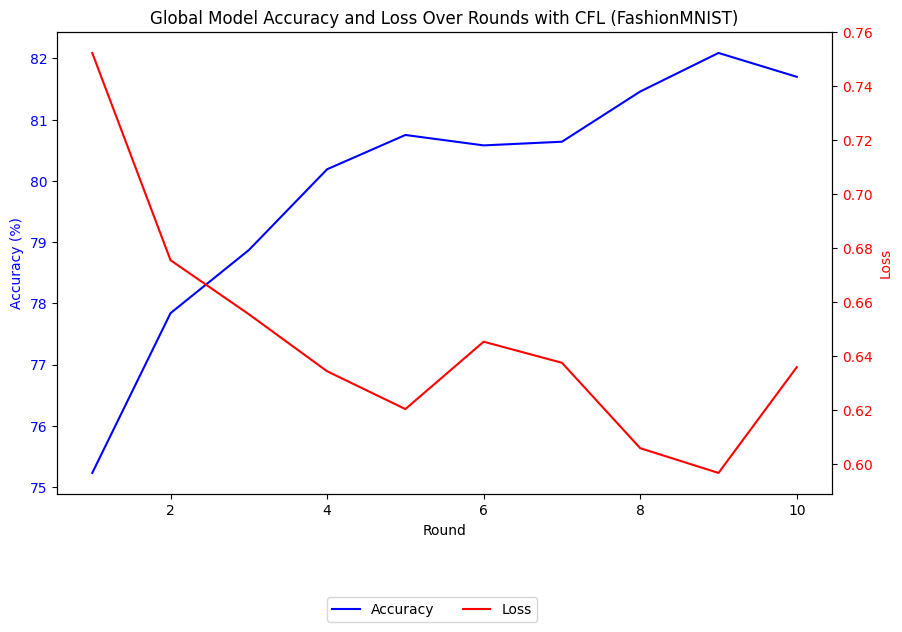

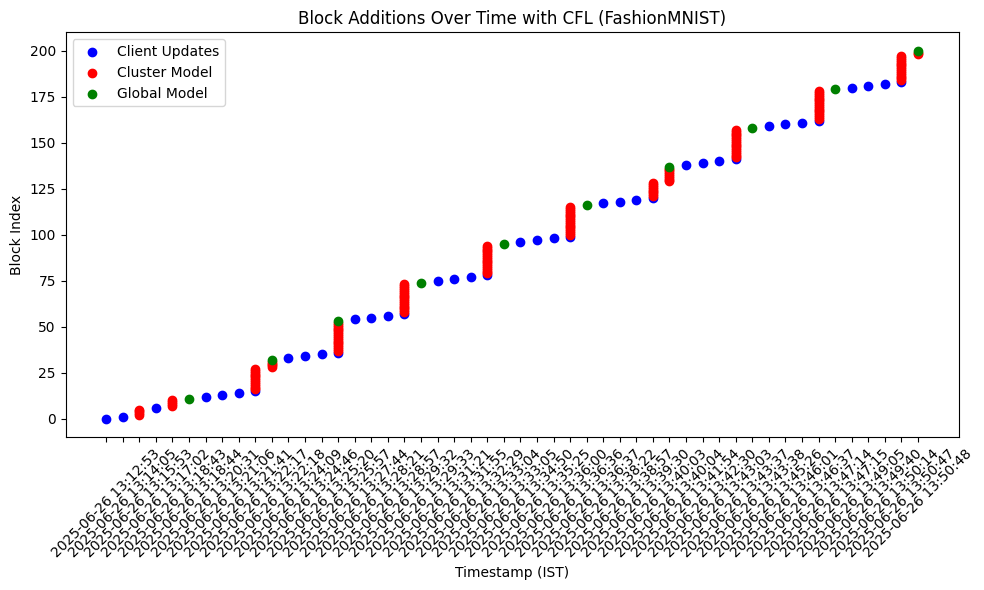

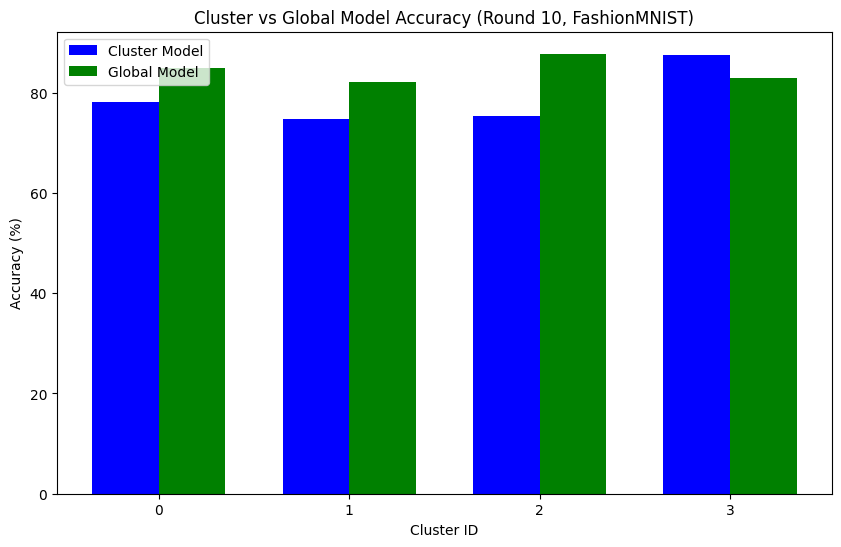

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25
NUM_EDGE_NODES = 4
LEARNING_RATE = 0.001
EPOCHS = 3
BATCH_SIZE = 32
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5
COSINE_THRESHOLD = 0.85
ROUND_TIMEOUT = 300.0
SAMPLE_SIZE = 5000

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])
fashionmnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
fashionmnist_test = datasets.FashionMNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    # Group data by class
    class_indices = [[] for _ in range(10)]  # 10 classes in FashionMNIST
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Assign 2-3 random classes to each client
    client_data = []
    for _ in range(num_clients):
        num_classes = random.randint(2, 3)
        selected_classes = random.sample(range(10), num_classes)
        indices = []
        for cls in selected_classes:
            # Take a portion of data from each class
            class_subset = random.sample(class_indices[cls], len(class_indices[cls]) // num_clients)
            indices.extend(class_subset)
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(fashionmnist_train, NUM_CLIENTS)
client_test_datasets = create_non_iid_data(fashionmnist_test, NUM_CLIENTS)

# Neural Network Model (CNN for FashionMNIST)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Changed to 1 input channel
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),  # Adjusted for 28x28 input after pooling
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids
        self.parameters = None

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        gradient = parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)
        self.prev_params = parameters
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0
        self.cached_proposal = None

    def verify_client_update(self, client_params, median_params):
        sample_size = min(SAMPLE_SIZE, len(client_params))
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        if len(self.parameter_updates) < 2:
            print(f"EdgeNode {self.id}: Insufficient updates for clustering")
            self.clusters = [Cluster(0, list(range(len(clients))))]
            return
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 3
        split_count = 0
        sample_size = min(SAMPLE_SIZE, len(self.parameter_updates[0][1]))
        sample_indices = np.random.choice(len(self.parameter_updates[0][1]), sample_size, replace=False)

        while split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                gradients = [grad[sample_indices] for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean) if norm_grad > 0 else 0.0
                    similarities.append(cos_sim)

                if max(similarities, default=0.0) > COSINE_THRESHOLD:
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            if not split_occurred:
                break
            self.clusters = new_clusters

        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)
        self.parameter_updates = []

    def exchange_parameter_updates(self, other_nodes, is_lead=False):
        if is_lead:
            print(f"EdgeNode {self.id} (lead) retained {len(self.clusters)} clusters")
        else:
            self.parameter_updates = []
            self.clusters = []
        for node in other_nodes:
            if is_lead:
                self.parameter_updates.extend(node.parameter_updates)
            else:
                node.parameter_updates = self.parameter_updates
                node.clusters = self.clusters
        print(f"EdgeNode {self.id} exchanged updates. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if self.cached_proposal is not None:
            return self.cached_proposal
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.cached_proposal = np.mean(cluster_params, axis=0)
        return self.cached_proposal

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = min(SAMPLE_SIZE, len(proposed_params))
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        if np.allclose(median_params, global_params, rtol=1e-5, atol=1e-8):
            print("Parameters are nearly identical, HSIC set to 1.0")
            return 1.0
        try:
            sample_size = min(SAMPLE_SIZE, len(median_params))
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        print("Triggering SC_4: Computing client rewards")
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            rewards.append((client.id, reward))
            print(f"Client {client.id} reward: {reward:.2f}")
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC value and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        self.parameter_updates = []
        self.cached_proposal = None
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total if total > 0 else 0.0
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0.0
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
cluster_accuracies = []
global_per_cluster_accuracies = []
test_loader = torch.utils.data.DataLoader(fashionmnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        if time.time() - round_start > ROUND_TIMEOUT:
            print(f"Round {round + 1} timed out after {ROUND_TIMEOUT} seconds")
            break
        consensus_start = time.time()
        client_start = time.time()
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            node.cached_proposal = None
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)

        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)

        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)
            print(f"Selected lead node: ID {lead_node.id} with reputation {lead_node.reputation:.2f}")
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node], is_lead=True)
            for node in edge_nodes:
                if node != lead_node:
                    node.clusters = lead_node.clusters
                    node.parameter_updates = lead_node.parameter_updates
                    node.global_parameters = lead_node.global_parameters
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer + param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

                # Cluster-specific evaluation
                cluster_accs = {}
                global_accs = {}
                for cluster in lead_node.clusters:
                    # Combine test data for clients in the cluster
                    cluster_test_data = []
                    for cid in cluster.client_ids:
                        cluster_test_data.extend(client_test_datasets[cid])
                    if not cluster_test_data:
                        print(f"Cluster {cluster.id} has no test data")
                        continue
                    cluster_test_loader = torch.utils.data.DataLoader(cluster_test_data, batch_size=64, shuffle=False)

                    # Evaluate cluster model
                    if cluster.parameters is not None:
                        cluster_model = SimpleNN()
                        pointer = 0
                        for param in cluster_model.parameters():
                            param_size = param.numel()
                            param.data = torch.from_numpy(cluster.parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                            pointer += param_size
                        cluster_acc, _ = evaluate_model(cluster_model, cluster_test_loader)
                        cluster_accs[cluster.id] = cluster_acc
                        print(f"Cluster {cluster.id} model accuracy: {cluster_acc:.2f}%")
                    else:
                        print(f"Cluster {cluster.id} has no parameters")
                        cluster_accs[cluster.id] = 0.0

                    # Evaluate global model on cluster data
                    global_acc, _ = evaluate_model(test_model, cluster_test_loader)
                    global_accs[cluster.id] = global_acc
                    print(f"Global model accuracy on Cluster {cluster.id} data: {global_acc:.2f}%")

                cluster_accuracies.append(cluster_accs)
                global_per_cluster_accuracies.append(global_accs)

                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                print(f"\nClusters formed in Round {round + 1}:")
                print(f"Lead Node ID: {lead_node.id}, Number of Clusters: {len(lead_node.clusters)}")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: Clients {cluster.client_ids}")
                print("Cluster counts after synchronization:")
                for node in edge_nodes:
                    print(f"Node {node.id}: {len(node.clusters)} clusters")

                phase_times['evaluation'].append(time.time() - eval_start)
                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
                node.cached_proposal = None
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:>10.2f} {total_time:>10.2f}")

# Print comparison table
print("\nPerformance Comparison Across Rounds:")
print(f"{'Round':<10} {'Cluster ID':<12} {'Cluster Acc (%)':<15} {'Global Acc (%)':<15} {'Clients':<20}")
for r in range(len(cluster_accuracies)):
    print(f"\nRound {r + 1}")
    for cid in cluster_accuracies[r]:
        print(f"{'':<10} {cid:<12} {cluster_accuracies[r][cid]:<15.2f} {global_per_cluster_accuracies[r][cid]:<15.2f} {lead_node.clusters[cid].client_ids if cid in [c.id for c in lead_node.clusters] else []}")

# Plot accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(accuracies) + 1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Global Model Accuracy and Loss Over Rounds with CFL (FashionMNIST)')
ax2 = ax1.twinx()
ax2.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('fl_cfl_trustchain_accuracy_loss_fashionmnist.png')
plt.show()
plt.close()

# Plot block additions
block_indices = [t[0] for t in edge_nodes[0].blockchain.block_timestamps]
block_times = [datetime.strptime(t[1], '%Y-%m-%d %H:%M:%S') for t in edge_nodes[0].blockchain.block_timestamps]
block_types = [t[2] for t in edge_nodes[0].blockchain.block_timestamps]
cluster_ids = [t[3] for t in edge_nodes[0].blockchain.block_timestamps]
plt.figure(figsize=(10, 6))
for i, (idx, t, is_agg, cid) in enumerate(edge_nodes[0].blockchain.block_timestamps):
    if is_agg:
        color, label = 'green', 'Global Model'
    elif cid is not None:
        color, label = 'red', 'Cluster Model'
    else:
        color, label = 'blue', 'Client Updates'
    plt.scatter(t, idx, c=color, label=label)
plt.xlabel('Timestamp (IST)')
plt.ylabel('Block Index')
plt.title('Block Additions Over Time with CFL (FashionMNIST)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fl_cfl_trustchain_block_additions_fashionmnist.png')
plt.show()
plt.close()

# Plot cluster vs global model accuracy comparison
if cluster_accuracies:
    final_round = len(cluster_accuracies) - 1
    cluster_ids = sorted(cluster_accuracies[final_round].keys())
    cluster_accs = [cluster_accuracies[final_round][cid] for cid in cluster_ids]
    global_accs = [global_per_cluster_accuracies[final_round][cid] for cid in cluster_ids]

    x = np.arange(len(cluster_ids))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, cluster_accs, width, label='Cluster Model', color='blue')
    ax.bar(x + width/2, global_accs, width, label='Global Model', color='green')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Cluster vs Global Model Accuracy (Round {final_round + 1}, FashionMNIST)')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_ids)
    ax.legend()
    plt.savefig('cluster_vs_global_accuracy_fashionmnist.png')
    plt.show()
    plt.close()

new_Result_Fashion_MNIST

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.0MB/s]



=== Round 1/10 (Started at 2025-07-06 13:01:11) ===
EdgeNode 0 verified and received update from client 0. Total updates: 1
EdgeNode 0 verified and received update from client 1. Total updates: 2
EdgeNode 0 verified and received update from client 2. Total updates: 3
EdgeNode 0 verified and received update from client 3. Total updates: 4
EdgeNode 0 verified and received update from client 4. Total updates: 5
EdgeNode 0 verified and received update from client 5. Total updates: 6
EdgeNode 0 verified and received update from client 6. Total updates: 7
EdgeNode 0 rejected update from client 7 due to low HSIC: 0.8963
EdgeNode 0 rejected update from client 8 due to low HSIC: 0.8939
EdgeNode 0 rejected update from client 9 due to low HSIC: 0.8784
EdgeNode 0 rejected update from client 10 due to low HSIC: 0.8627
EdgeNode 0 rejected update from client 11 due to low HSIC: 0.8603
EdgeNode 0 rejected update from client 12 due to low HSIC: 0.8549
EdgeNode 0 rejected update from client 13 due to l

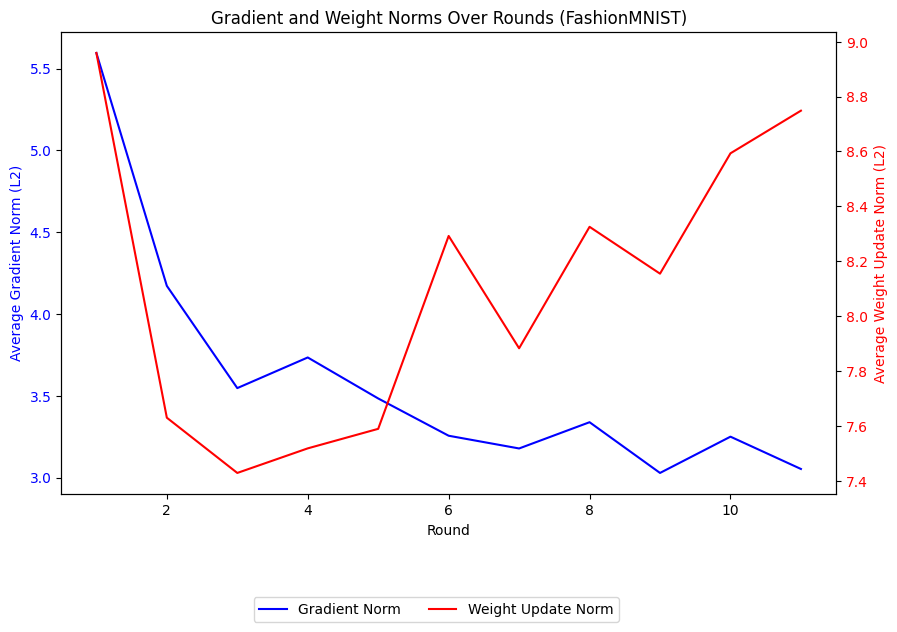

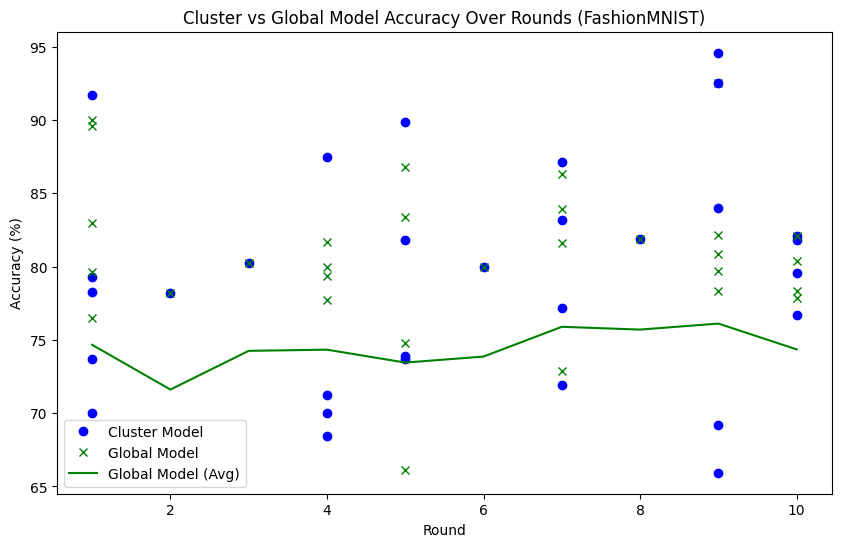

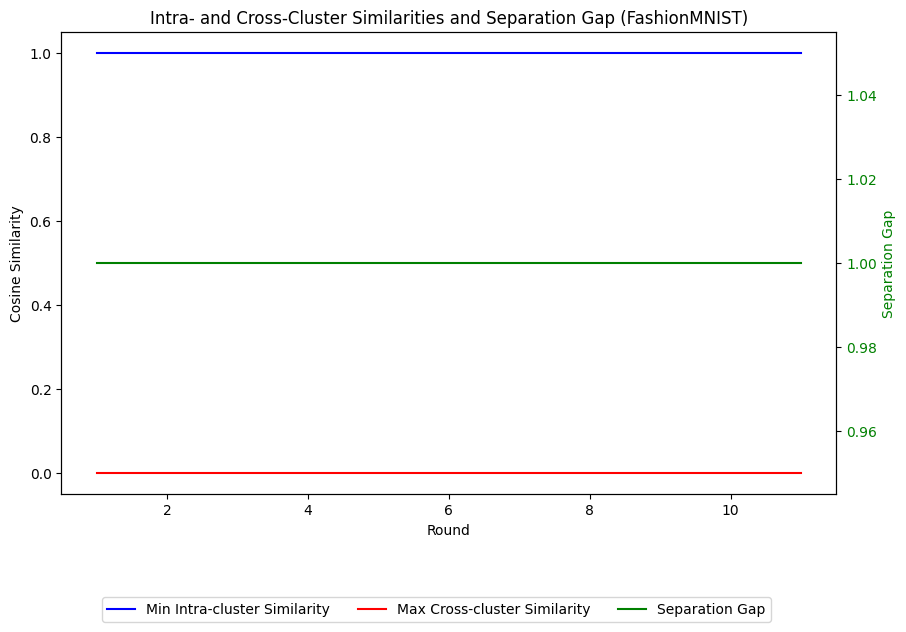

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import hashlib
import time
from datetime import datetime
import pytz

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_CLIENTS = 25
NUM_EDGE_NODES = 4
LEARNING_RATE = 0.001
EPOCHS = 3
BATCH_SIZE = 32
NUM_ROUNDS = 10
WINDOW_SIZE = 15
DECAY_RATE = 0.9
HSIC_LAMBDA = 0.5
MAX_REJECTIONS = 2
REPUTATION_ALPHA = 0.5
REWARD_POOL = 100.0
HSIC_THRESHOLD = 0.9
CONSENSUS_THRESHOLD = 0.5
COSINE_THRESHOLD = 0.85
ROUND_TIMEOUT = 300.0
SAMPLE_SIZE = 5000

# Timezone for IST
IST = pytz.timezone('Asia/Kolkata')

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])
fashionmnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
fashionmnist_test = datasets.FashionMNIST('./data', train=False, transform=transform)

# Non-IID data distribution
def create_non_iid_data(dataset, num_clients):
    class_indices = [[] for _ in range(10)]
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    client_data = []
    for _ in range(num_clients):
        num_classes = random.randint(2, 3)
        selected_classes = random.sample(range(10), num_classes)
        indices = []
        for cls in selected_classes:
            class_subset = random.sample(class_indices[cls], len(class_indices[cls]) // num_clients)
            indices.extend(class_subset)
        client_data.append([(dataset[i][0], dataset[i][1]) for i in indices])
    return client_data

client_datasets = create_non_iid_data(fashionmnist_train, NUM_CLIENTS)
client_test_datasets = create_non_iid_data(fashionmnist_test, NUM_CLIENTS)

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

# Cluster Class for CFL
class Cluster:
    def __init__(self, id, client_ids):
        self.id = id
        self.client_ids = client_ids
        self.parameters = None

    def aggregate(self, client_updates):
        if not client_updates:
            return None
        valid_params = [params for _, params, _ in client_updates]
        self.parameters = np.mean(valid_params, axis=0)
        return self.parameters

# Block for Blockchain
class Block:
    def __init__(self, index, transactions, prev_hash, global_params, hsic_value, scores, rewards, votes, is_aggregated, is_cluster=False, cluster_id=None, timestamp=None):
        self.index = index
        self.transactions = transactions
        self.prev_hash = prev_hash
        self.global_params = global_params
        self.hsic_value = hsic_value
        self.scores = scores
        self.rewards = rewards
        self.votes = votes
        self.is_aggregated = is_aggregated
        self.is_cluster = is_cluster
        self.cluster_id = cluster_id
        self.timestamp = timestamp
        self.hash = self.compute_hash()

    def compute_hash(self):
        data = f"{self.index}{self.transactions}{self.prev_hash}{self.global_params}{self.hsic_value}{self.scores}{self.rewards}{self.votes}{self.is_aggregated}{self.is_cluster}{self.cluster_id}{self.timestamp}"
        return hashlib.sha256(data.encode()).hexdigest()

# Blockchain
class Blockchain:
    def __init__(self):
        genesis_timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        self.chain = [Block(0, [], "0", None, 0.0, [], [], [], False, False, None, genesis_timestamp)]
        self.block_timestamps = [(0, genesis_timestamp, False, None)]

    def append_block(self, block):
        if block.prev_hash == self.chain[-1].hash:
            self.chain.append(block)
            self.block_timestamps.append((block.index, block.timestamp, block.is_aggregated, block.cluster_id))
            block_type = 'Global Model' if block.is_aggregated else ('Cluster Model' if block.is_cluster else 'Client Updates')
            print(f"Block {block.index} added to blockchain at {block.timestamp} (Type: {block_type}, Cluster: {block.cluster_id if block.is_cluster else 'N/A'})")

# Client
class Client:
    def __init__(self, id, dataset, initial_model=None):
        self.id = id
        self.dataset = dataset
        self.model = SimpleNN()
        if initial_model is not None:
            self.model.load_state_dict(initial_model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        self.contribution_score = len(dataset)
        self.local_loss = float('inf')
        self.prev_params = None
        self.gradient_norms = []
        self.weight_norms = []

    def local_update(self):
        self.model.train()
        data_subset = random.sample(self.dataset, min(BATCH_SIZE * EPOCHS, len(self.dataset)))
        total_loss = 0.0
        current_params = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        gradients = []
        for epoch in range(EPOCHS):
            for i in range(0, len(data_subset), BATCH_SIZE):
                batch = data_subset[i:i + BATCH_SIZE]
                inputs = torch.stack([x[0] for x in batch])
                labels = torch.tensor([x[1] for x in batch])
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                gradients.append(np.concatenate([param.grad.flatten().detach().numpy() for param in self.model.parameters()]))
        avg_loss = total_loss / (len(data_subset) / BATCH_SIZE * EPOCHS)
        loss_reduction = max(0, self.local_loss - avg_loss)
        self.local_loss = avg_loss
        self.contribution_score = len(self.dataset) * (1 + loss_reduction)
        parameters = np.concatenate([param.data.flatten().detach().numpy() for param in self.model.parameters()])
        signature = hashlib.sha256(parameters.tobytes()).hexdigest()
        gradient = np.mean(gradients, axis=0) if gradients else np.zeros_like(parameters)
        self.gradient_norms.append(np.linalg.norm(gradient))
        self.weight_norms.append(np.linalg.norm(parameters - self.prev_params if self.prev_params is not None else np.zeros_like(parameters)))
        self.prev_params = parameters
        return parameters, signature, gradient

    def update_model(self, cluster_parameters):
        if cluster_parameters is not None:
            pointer = 0
            for param in self.model.parameters():
                param_size = param.numel()
                param.data = torch.from_numpy(cluster_parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                pointer += param_size

# Edge Node
class EdgeNode:
    def __init__(self, id):
        self.id = id
        self.clusters = []
        self.parameter_updates = []
        self.global_parameters = None
        self.blockchain = Blockchain()
        self.scores = {}
        self.hsic_values = []
        self.reputation = 1.0
        self.cached_proposal = None
        self.intra_similarities = []
        self.cross_similarities = []
        self.separation_gaps = []

    def verify_client_update(self, client_params, median_params):
        sample_size = min(SAMPLE_SIZE, len(client_params))
        indices = np.random.choice(len(client_params), sample_size, replace=False)
        try:
            hsic = abs(np.corrcoef(client_params[indices], median_params[indices])[0, 1])
            return hsic >= HSIC_THRESHOLD, hsic
        except:
            return True, 1.0

    def receive_parameter_update(self, client_id, parameter_update, signature, gradient, median_params):
        computed_hash = hashlib.sha256(parameter_update.tobytes()).hexdigest()
        if computed_hash != signature:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to invalid signature")
            return
        is_valid, hsic = self.verify_client_update(parameter_update, median_params)
        if not is_valid:
            print(f"EdgeNode {self.id} rejected update from client {client_id} due to low HSIC: {hsic:.4f}")
            return
        self.parameter_updates.append((client_id, parameter_update, signature, gradient))
        print(f"EdgeNode {self.id} verified and received update from client {client_id}. Total updates: {len(self.parameter_updates)}")

    def perform_cfl_clustering(self, clients):
        print(f"EdgeNode {self.id}: Performing CFL clustering")
        if len(self.parameter_updates) < 2:
            print(f"EdgeNode {self.id}: Insufficient updates for clustering")
            self.clusters = [Cluster(0, list(range(len(clients))))]
            return
        self.clusters = [Cluster(0, list(range(len(clients))))]
        max_splits = 3
        split_count = 0
        sample_size = min(SAMPLE_SIZE, len(self.parameter_updates[0][1]))
        sample_indices = np.random.choice(len(self.parameter_updates[0][1]), sample_size, replace=False)

        intra_sims = []
        cross_sims = []
        while split_count < max_splits:
            split_occurred = False
            new_clusters = []
            cluster_id = len(self.clusters)

            for cluster in self.clusters:
                cluster_updates = [(cid, params, sig, grad) for cid, params, sig, grad in self.parameter_updates if cid in cluster.client_ids]
                if len(cluster_updates) < 2:
                    new_clusters.append(cluster)
                    continue

                gradients = [grad[sample_indices] for _, _, _, grad in cluster_updates]
                mean_gradient = np.mean(gradients, axis=0)
                norm_mean = np.linalg.norm(mean_gradient)
                if norm_mean == 0:
                    new_clusters.append(cluster)
                    continue

                similarities = []
                for grad in gradients:
                    norm_grad = np.linalg.norm(grad)
                    cos_sim = np.dot(grad, mean_gradient) / (norm_grad * norm_mean) if norm_grad > 0 else 0.0
                    similarities.append(cos_sim)

                if max(similarities, default=0.0) > COSINE_THRESHOLD:
                    split_occurred = True
                    split_count += 1
                    group1, group2 = [], []
                    for i, sim in enumerate(similarities):
                        client_id = cluster_updates[i][0]
                        if sim >= np.mean(similarities):
                            group1.append(client_id)
                        else:
                            group2.append(client_id)

                    if group1 and group2:
                        new_clusters.append(Cluster(cluster.id, group1))
                        new_clusters.append(Cluster(cluster_id, group2))
                        cluster_id += 1

                        # Compute intracluster and cross-cluster similarities
                        group1_grads = [grad[sample_indices] for _, _, _, grad in cluster_updates if cluster_updates[i][0] in group1]
                        group2_grads = [grad[sample_indices] for _, _, _, grad in cluster_updates if cluster_updates[i][0] in group2]
                        if group1_grads and group2_grads:
                            intra_sim1 = np.mean([np.dot(g1, g2) / (np.linalg.norm(g1) * np.linalg.norm(g2) + 1e-10) for g1 in group1_grads for g2 in group1_grads if not np.array_equal(g1, g2)])
                            intra_sim2 = np.mean([np.dot(g1, g2) / (np.linalg.norm(g1) * np.linalg.norm(g2) + 1e-10) for g1 in group2_grads for g2 in group2_grads if not np.array_equal(g1, g2)])
                            intra_sim = min(intra_sim1, intra_sim2) if not np.isnan(intra_sim1) and not np.isnan(intra_sim2) else 1.0
                            cross_sim = np.mean([np.dot(g1, g2) / (np.linalg.norm(g1) * np.linalg.norm(g2) + 1e-10) for g1 in group1_grads for g2 in group2_grads])
                            intra_sims.append(intra_sim)
                            cross_sims.append(cross_sim)
                    else:
                        new_clusters.append(cluster)
                else:
                    new_clusters.append(cluster)

            if not split_occurred:
                break
            self.clusters = new_clusters

        self.intra_similarities.append(np.min(intra_sims) if intra_sims else 1.0)
        self.cross_similarities.append(np.max(cross_sims) if cross_sims else 0.0)
        self.separation_gaps.append(self.intra_similarities[-1] - self.cross_similarities[-1])
        print(f"EdgeNode {self.id}: Formed {len(self.clusters)} clusters: {[len(c.client_ids) for c in self.clusters]} clients")
        print(f"Intra-cluster similarity: {self.intra_similarities[-1]:.4f}, Cross-cluster similarity: {self.cross_similarities[-1]:.4f}, Separation gap: {self.separation_gaps[-1]:.4f}")

    def aggregate_clusters(self):
        for cluster in self.clusters:
            cluster_updates = [(cid, params, sig) for cid, params, sig, _ in self.parameter_updates if cid in cluster.client_ids]
            if cluster_updates:
                cluster.aggregate(cluster_updates)
                print(f"EdgeNode {self.id}: Aggregated cluster {cluster.id} with {len(cluster_updates)} updates")
                timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
                block = Block(len(self.blockchain.chain), cluster_updates, self.blockchain.chain[-1].hash,
                              cluster.parameters, 0.0, [], [], [], False, True, cluster.id, timestamp)
                self.blockchain.append_block(block)
        self.parameter_updates = []

    def exchange_parameter_updates(self, other_nodes, is_lead=False):
        if is_lead:
            print(f"EdgeNode {self.id} (lead) retained {len(self.clusters)} clusters")
        else:
            self.parameter_updates = []
            self.clusters = []
        for node in other_nodes:
            if is_lead:
                self.parameter_updates.extend(node.parameter_updates)
            else:
                node.parameter_updates = self.parameter_updates
                node.clusters = self.clusters
        print(f"EdgeNode {self.id} exchanged updates. Total updates: {len(self.parameter_updates)}, Clusters: {len(self.clusters)}")

    def propose_aggregation(self):
        if self.cached_proposal is not None:
            return self.cached_proposal
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to propose")
            return None
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.cached_proposal = np.mean(cluster_params, axis=0)
        return self.cached_proposal

    def vote_on_proposal(self, proposed_params, own_params):
        if proposed_params is None or own_params is None:
            return False
        sample_size = min(SAMPLE_SIZE, len(proposed_params))
        indices = np.random.choice(len(proposed_params), sample_size, replace=False)
        try:
            similarity = np.corrcoef(proposed_params[indices], own_params[indices])[0, 1]
            return similarity >= 0.95
        except:
            return False

    def perform_consensus(self, edge_nodes, proposed_params):
        print(f"Triggering SC_1: Consensus for model validation")
        start_time = time.time()
        votes = []
        total_stake = sum(node.reputation for node in edge_nodes)
        for node in edge_nodes:
            own_params = node.propose_aggregation()
            vote = node.vote_on_proposal(proposed_params, own_params)
            votes.append((node.id, vote, node.reputation))
            print(f"EdgeNode {node.id} voted: {'Approve' if vote else 'Reject'} (Reputation: {node.reputation:.2f})")
        approved_stake = sum(reputation for _, vote, reputation in votes if vote)
        approved_nodes = sum(1 for _, vote, _ in votes if vote)
        if total_stake > 0 and approved_stake / total_stake > CONSENSUS_THRESHOLD:
            print(f"Consensus reached by {approved_nodes}/{len(edge_nodes)} nodes (Stake: {approved_stake:.2f}/{total_stake:.2f})")
            for node in edge_nodes:
                if node.id in [vid for vid, vote, _ in votes if vote]:
                    node.reputation = min(2.0, node.reputation * 1.05)
                else:
                    node.reputation = max(0.1, node.reputation * 0.95)
            print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
            return True, votes
        print(f"Consensus failed: {approved_nodes}/{len(edge_nodes)} nodes approved")
        print(f"SC_1 completed in {time.time() - start_time:.2f} seconds")
        return False, votes

    def compute_global_parameters(self):
        cluster_params = [c.parameters for c in self.clusters if c.parameters is not None]
        if not cluster_params:
            print(f"EdgeNode {self.id}: No cluster parameters to aggregate")
            return None
        self.global_parameters = np.mean(cluster_params, axis=0)
        self.median_parameters = np.median(cluster_params, axis=0) if cluster_params else np.zeros_like(self.global_parameters)
        return self.global_parameters

    def create_client_block(self):
        if not self.parameter_updates:
            print(f"EdgeNode {self.id}: No parameter updates to create client block")
            return
        print(f"Creating client update block for EdgeNode {self.id}")
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), self.parameter_updates, self.blockchain.chain[-1].hash,
                      None, 0.0, [], [], [], False, False, None, timestamp)
        self.blockchain.append_block(block)
        print(f"Client update block {block.index} created")

    def compute_hsic(self, median_params, global_params):
        print("Starting HSIC computation")
        start_time = time.time()
        if np.allclose(median_params, global_params, rtol=1e-5, atol=1e-8):
            print("Parameters are nearly identical, HSIC set to 1.0")
            return 1.0
        try:
            sample_size = min(SAMPLE_SIZE, len(median_params))
            indices = np.random.choice(len(median_params), sample_size, replace=False)
            median_sample = median_params[indices]
            global_sample = global_params[indices]
            corr = np.corrcoef(median_sample, global_sample)[0, 1]
            hsic = abs(corr)
            print(f"HSIC computed: {hsic:.4f}")
            return hsic
        except Exception as e:
            print(f"HSIC computation failed: {str(e)}")
            return 1.0
        finally:
            print(f"HSIC computation completed in {time.time() - start_time:.2f} seconds")

    def perform_paa(self, global_params, median_params):
        print(f"Triggering SC_2: Post-Aggregation Auditing (PAA) for model verification")
        start_time = time.time()
        hsic = self.compute_hsic(median_params, global_params)
        if np.isnan(hsic) or hsic < 0:
            print("Invalid HSIC value, approving model as fallback")
            self.hsic_values.append(1.0)
            self.reputation = max(0.1, self.reputation * 0.9)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True
        if len(self.hsic_values) >= WINDOW_SIZE:
            h = self.hsic_values[-WINDOW_SIZE:]
            tau = min(h) - HSIC_LAMBDA * np.std(h) if np.std(h) > 0 else min(h)
            if hsic >= tau:
                print(f"SC_2 approved aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.hsic_values.append(hsic)
                self.reputation = min(2.0, self.reputation * 1.1)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return True
            else:
                print(f"SC_2 rejected aggregated model. HSIC: {hsic:.4f}, Threshold: {tau:.4f}")
                self.reputation = max(0.1, self.reputation * 0.9)
                print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
                return False
        else:
            self.hsic_values.append(hsic)
            print(f"SC_2 approved (initial round). HSIC: {hsic:.4f}")
            self.reputation = min(2.0, self.reputation * 1.1)
            print(f"SC_2 completed in {time.time() - start_time:.2f} seconds")
            return True

    def compute_rewards(self, clients):
        print("Triggering SC_4: Computing client rewards")
        total_score = sum(client.contribution_score for client in clients)
        rewards = []
        for client in clients:
            reward = (client.contribution_score / total_score * REWARD_POOL) if total_score > 0 else 0
            rewards.append((client.id, reward))
            print(f"Client {client.id} reward: {reward:.2f}")
        return rewards

    def create_block(self, clients, votes):
        if not self.clusters:
            print(f"EdgeNode {self.id}: No clusters to create block")
            return None
        print(f"Triggering SC_3: Storing HSIC value and creating block")
        start_time = time.time()
        global_params = self.compute_global_parameters()
        hsic_value = self.hsic_values[-1] if self.hsic_values else 0.0
        scores = list(self.scores.items())
        rewards = self.compute_rewards(clients)
        timestamp = datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')
        block = Block(len(self.blockchain.chain), [], self.blockchain.chain[-1].hash,
                      global_params, hsic_value, scores, rewards, votes, True, False, None, timestamp)
        self.blockchain.append_block(block)
        self.parameter_updates = []
        self.cached_proposal = None
        print(f"SC_3 completed: Block {block.index} stored with HSIC {hsic_value:.4f}")
        print(f"SC_3 completed in {time.time() - start_time:.2f} seconds")
        return global_params

# Evaluation
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total if total > 0 else 0.0
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0.0
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    return accuracy, avg_loss

# Main Simulation
start_time = time.time()
initial_model = SimpleNN()
clients = [Client(i, client_datasets[i], initial_model) for i in range(NUM_CLIENTS)]
edge_nodes = [EdgeNode(i) for i in range(NUM_EDGE_NODES)]
accuracies = []
losses = []
cluster_accuracies = []
global_per_cluster_accuracies = []
gradient_norms = []
weight_norms = []
intra_similarities = []
cross_similarities = []
separation_gaps = []
cluster_formations = []
test_loader = torch.utils.data.DataLoader(fashionmnist_test, batch_size=64, shuffle=False)
phase_times = {'clustering': [], 'consensus': [], 'client_updates': [], 'aggregation': [], 'paa': [], 'block_creation': [], 'evaluation': []}

initial_parameters = np.concatenate([param.data.flatten().detach().numpy() for param in initial_model.parameters()])
for node in edge_nodes:
    node.global_parameters = initial_parameters

for round in range(NUM_ROUNDS):
    round_start = time.time()
    print(f"\n=== Round {round + 1}/{NUM_ROUNDS} (Started at {datetime.now(IST).strftime('%Y-%m-%d %H:%M:%S')}) ===")
    rejection_count = 0

    while rejection_count < MAX_REJECTIONS:
        if time.time() - round_start > ROUND_TIMEOUT:
            print(f"Round {round + 1} timed out after {ROUND_TIMEOUT} seconds")
            break
        consensus_start = time.time()
        client_start = time.time()
        median_params = np.median([client.local_update()[0] for client in clients], axis=0)
        for node in edge_nodes:
            node.parameter_updates = []
            node.cached_proposal = None
            for client in clients:
                client.update_model(node.global_parameters)
                params, signature, gradient = client.local_update()
                node.receive_parameter_update(client.id, params, signature, gradient, median_params)
            node.create_client_block()
        phase_times['client_updates'].append(time.time() - client_start)
        gradient_norms.append(np.mean([client.gradient_norms[-1] for client in clients]))
        weight_norms.append(np.mean([client.weight_norms[-1] for client in clients]))

        clustering_start = time.time()
        for node in edge_nodes:
            node.perform_cfl_clustering(clients)
            node.aggregate_clusters()
        phase_times['clustering'].append(time.time() - clustering_start)
        intra_similarities.append(edge_nodes[0].intra_similarities[-1])
        cross_similarities.append(edge_nodes[0].cross_similarities[-1])
        separation_gaps.append(edge_nodes[0].separation_gaps[-1])

        agg_start = time.time()
        proposed_params = edge_nodes[0].propose_aggregation()
        consensus_reached, votes = edge_nodes[0].perform_consensus(edge_nodes, proposed_params)
        phase_times['consensus'].append(time.time() - consensus_start)
        phase_times['aggregation'].append(time.time() - agg_start)

        if consensus_reached:
            paa_start = time.time()
            lead_node = max(edge_nodes, key=lambda n: n.reputation)
            print(f"Selected lead node: ID {lead_node.id} with reputation {lead_node.reputation:.2f}")
            lead_node.exchange_parameter_updates([n for n in edge_nodes if n != lead_node], is_lead=True)
            for node in edge_nodes:
                if node != lead_node:
                    node.clusters = lead_node.clusters
                    node.parameter_updates = lead_node.parameter_updates
                    node.global_parameters = lead_node.global_parameters
            global_params = lead_node.compute_global_parameters()
            if global_params is not None and lead_node.perform_paa(global_params, lead_node.median_parameters):
                phase_times['paa'].append(time.time() - paa_start)
                block_start = time.time()
                global_params = lead_node.create_block(clients, votes)
                for node in edge_nodes:
                    if node != lead_node:
                        node.blockchain = lead_node.blockchain
                        node.global_parameters = global_params
                        node.parameter_updates = []
                phase_times['block_creation'].append(time.time() - block_start)

                eval_start = time.time()
                test_model = SimpleNN()
                pointer = 0
                for param in test_model.parameters():
                    param_size = param.numel()
                    param.data = torch.from_numpy(global_params[pointer:pointer + param_size]).reshape(param.shape).float()
                    pointer += param_size
                accuracy, loss = evaluate_model(test_model, test_loader)
                accuracies.append(accuracy)
                losses.append(loss)
                print(f"Global model accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

                cluster_accs = {}
                global_accs = {}
                cluster_formation = {}
                for cluster in lead_node.clusters:
                    cluster_test_data = []
                    for cid in cluster.client_ids:
                        cluster_test_data.extend(client_test_datasets[cid])
                    if not cluster_test_data:
                        print(f"Cluster {cluster.id} has no test data")
                        continue
                    cluster_test_loader = torch.utils.data.DataLoader(cluster_test_data, batch_size=64, shuffle=False)

                    if cluster.parameters is not None:
                        cluster_model = SimpleNN()
                        pointer = 0
                        for param in cluster_model.parameters():
                            param_size = param.numel()
                            param.data = torch.from_numpy(cluster.parameters[pointer:pointer + param_size]).reshape(param.shape).float()
                            pointer += param_size
                        cluster_acc, _ = evaluate_model(cluster_model, cluster_test_loader)
                        cluster_accs[cluster.id] = cluster_acc
                        print(f"Cluster {cluster.id} model accuracy: {cluster_acc:.2f}%")
                    else:
                        print(f"Cluster {cluster.id} has no parameters")
                        cluster_accs[cluster.id] = 0.0

                    global_acc, _ = evaluate_model(test_model, cluster_test_loader)
                    global_accs[cluster.id] = global_acc
                    print(f"Global model accuracy on Cluster {cluster.id} data: {global_acc:.2f}%")
                    cluster_formation[cluster.id] = len(cluster.client_ids)

                cluster_accuracies.append(cluster_accs)
                global_per_cluster_accuracies.append(global_accs)
                cluster_formations.append(cluster_formation)

                for client in clients:
                    for cluster in lead_node.clusters:
                        if client.id in cluster.client_ids:
                            client.update_model(cluster.parameters)
                            break

                print(f"\nClusters formed in Round {round + 1}:")
                print(f"Lead Node ID: {lead_node.id}, Number of Clusters: {len(lead_node.clusters)}")
                for cluster in lead_node.clusters:
                    print(f"Cluster {cluster.id}: {len(cluster.client_ids)} clients")
                print("Cluster counts after synchronization:")
                for node in edge_nodes:
                    print(f"Node {node.id}: {len(node.clusters)} clusters")

                phase_times['evaluation'].append(time.time() - eval_start)
                break
        else:
            print(f"Consensus rejected. Retrying (Attempt {rejection_count + 1}/{MAX_REJECTIONS})")
            rejection_count += 1
            for node in edge_nodes:
                node.parameter_updates = []
                node.clusters = []
                node.cached_proposal = None
            phase_times['paa'].append(time.time() - agg_start)
            if rejection_count >= MAX_REJECTIONS:
                print("Max rejections reached. Skipping round.")
                break

    round_time = time.time() - round_start
    print(f"Round {round + 1} completed in {round_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nFederated learning with CFL and TrustChain completed in {total_time:.2f} seconds!")

# Computational Overhead
print("\nComputational Overhead (seconds):")
print(f"{'Phase':<20} {'Mean':>10} {'Std':>10} {'Total':>10}")
for phase, times in phase_times.items():
    mean_time = np.mean(times) if times else 0.0
    std_time = np.std(times) if times else 0.0
    total_time = sum(times) if times else 0.0
    print(f"{phase:<20} {mean_time:>10.2f} {std_time:>10.2f} {total_time:>10.2f}")

# Cluster Formation Table
print("\nCluster Formation Across Rounds:")
print(f"{'Round':<10} {'Cluster ID':<12} {'Num Clients':<15}")
for r in range(len(cluster_formations)):
    print(f"\nRound {r + 1}")
    for cid, num_clients in cluster_formations[r].items():
        print(f"{'':<10} {cid:<12} {num_clients:<15}")

# Plot Gradient and Weight Norms
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(gradient_norms) + 1), gradient_norms, 'b-', label='Gradient Norm')
ax1.set_xlabel('Round')
ax1.set_ylabel('Average Gradient Norm (L2)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Gradient and Weight Norms Over Rounds (FashionMNIST)')
ax2 = ax1.twinx()
ax2.plot(range(1, len(weight_norms) + 1), weight_norms, 'r-', label='Weight Update Norm')
ax2.set_ylabel('Average Weight Update Norm (L2)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('gradient_weight_norms_fashionmnist.png')
plt.show()
plt.close()

# Plot Cluster vs Global Model Accuracy Over Rounds
fig, ax = plt.subplots(figsize=(10, 6))
for r in range(len(cluster_accuracies)):
    for cid in cluster_accuracies[r]:
        ax.plot(r + 1, cluster_accuracies[r][cid], 'o', color='blue', label='Cluster Model' if r == 0 and cid == min(cluster_accuracies[r].keys()) else "")
        ax.plot(r + 1, global_per_cluster_accuracies[r][cid], 'x', color='green', label='Global Model' if r == 0 and cid == min(cluster_accuracies[r].keys()) else "")
ax.plot(range(1, len(accuracies) + 1), accuracies, 'g-', label='Global Model (Avg)')
ax.set_xlabel('Round')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Cluster vs Global Model Accuracy Over Rounds (FashionMNIST)')
ax.legend()
plt.savefig('cluster_vs_global_accuracy_trend_fashionmnist.png')
plt.show()
plt.close()

# Plot Intra- and Cross-Cluster Similarities
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, len(intra_similarities) + 1), intra_similarities, 'b-', label='Min Intra-cluster Similarity')
ax1.plot(range(1, len(cross_similarities) + 1), cross_similarities, 'r-', label='Max Cross-cluster Similarity')
ax1.set_xlabel('Round')
ax1.set_ylabel('Cosine Similarity', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_title('Intra- and Cross-Cluster Similarities and Separation Gap (FashionMNIST)')
ax2 = ax1.twinx()
ax2.plot(range(1, len(separation_gaps) + 1), separation_gaps, 'g-', label='Separation Gap')
ax2.set_ylabel('Separation Gap', color='g')
ax2.tick_params(axis='y', labelcolor='g')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.savefig('similarity_separation_gap_fashionmnist.png')
plt.show()
plt.close()